# DPO

## Setup

In [1]:
from math import nan, isnan, inf, isfinite

import abc
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import shutil
import sys

HOME = os.path.expanduser('~')

!{sys.executable} -m pip install slurmqueen -q # pypi.org/project/slurmqueen

import slurmqueen
from slurmqueen.experiment import Command
from slurmqueen.slurm_experiment import SlurmExperiment

def getRunScript(slurmMemCap, strictFlag):
    script = [
        '',
        f'#SBATCH --mem={slurmMemCap}g',
        f'#SBATCH --mail-type=all'
    ]
    script += [
        '',
        '#SBATCH --exclusive',
        '#SBATCH --constraint=ivybridge'
    ] if strictFlag else []
    script += [
        '',
        'export XALT_EXECUTABLE_TRACKING=no',
        'ml load GCC/10.3.0 Python/3.9.5'
    ]
    return '\n'.join(script)

def getFilePaths(dirPath, fileNameEnds=set(), excludedFileNameEnds=set()):
    assert isinstance(fileNameEnds, set)
    assert isinstance(excludedFileNameEnds, set)
    dirPath = dirPath.rstrip('/')
    filePaths = []
    for (subdirPath, _, fileNames) in os.walk(os.path.expanduser(dirPath)):
        for fileName in fileNames:
            if not fileNameEnds or any(
                [fileName.endswith(fileNameEnd) for fileNameEnd in fileNameEnds]
            ):
                if all([not fileName.endswith(suffix) for suffix in excludedFileNameEnds]):
                    filePath = os.path.join(subdirPath, fileName)
                    filePaths.append(filePath)
    return sorted(filePaths)

In [2]:
DEPENDENCIES = [ # these files will be copied to NOTS (/scratch/) by SlurmQueen
    'dpmc.py',
    'wrapper.py',
    'postprocessor.py'
]

class Exp(SlurmExperiment, metaclass=abc.ABCMeta):
    def prepare_server(self, inst): # after copying files and before submitting jobs
        files = [inst.remote_experiment_path(f) for f in DEPENDENCIES]
        cmds = [f'chmod +x {" ".join(files)}']
        for relPath in ['bin', 'benchmarks']:
            projectPath = f'/projects/vardi/vhp1/{relPath}'
            scratchPath = inst.remote_experiment_path(relPath)
            cmds.append(f'mkdir -p {os.path.dirname(scratchPath)}')
            cmds.append(f'ln -sf {projectPath} {scratchPath}')
        cmd = ' && '.join(cmds)
        inst.server.execute(cmd)

    def getInst(self):
        netid = 'vhp1'
        return Inst(
            self,
            slurmqueen.ExperimentConfig(
                server=slurmqueen.SlurmServer('nots.rice.edu', netid, f'{HOME}/.ssh/id_rsa'),
                partition='scavenge',
                local_directory=os.getcwd(),
                remote_directory=f'/scratch/{netid}'
            )
        )

    @abc.abstractmethod
    def getWrapperDict(self, benchmarkPath):
        pass

    def getCmd(self, benchmarkPath):
        kwargs = {'cf': benchmarkPath, 'runner': 1}
        return Command(
            'python3',
            'wrapper.py',
            **kwargs,
            **self.getWrapperDict(benchmarkPath),
        ) | Command('python3', 'postprocessor.py')

    def getCmds(self):
        cmds = []
        filePaths = getFilePaths(self.benchmarksPath)
        for i in range(len(filePaths)):
            if not self.actualTasks or i in self.actualTasks:
                cmds.append(self.getCmd(filePaths[i]))
        return cmds

def getIntDigits(num): # SlurmQueen
    return len(str(num))

def copyFile(oldPath, newPath):
    if os.path.exists(newPath):
        raise Exception(f'Existing file: {newPath}')
    shutil.copyfile(oldPath, newPath)

In [3]:
def justifyInt(num, digits):
    assert isinstance(num, int)
    return str(num).rjust(digits, '0')

class Inst(slurmqueen.slurm_experiment.SlurmInstance):
    def getTable(self, q):
        df = self.query(q)
        return df.rename(
            columns={
                col: f'{col}{self._exp.suffix}' for col in df.head() if col not in {'file', 'cf', 'base'}
            }
        )

    def runExp(self):
        p = self._exp.id
        if os.path.exists(p):
            answer = input(f'Delete existing local file ({p}) [Y/N]: ')
            if answer.upper() == 'Y':
                shutil.rmtree(p)
            else:
                print(f'Skipped experiment ({p})')
                return
        self.run(len(self._exp.getCmds()), f'0:{self._exp.slurmTimeCap}')

    def checkData(self, allSatFlag=True):
        def checkFile(filePath):
            if os.path.isfile(filePath):
                return True
            else:
                print(f'Missing file:\t{filePath}')
                return False

        benchmarkPaths = getFilePaths(self._exp.benchmarksPath)
        for i in range(len(benchmarkPaths)):
            for ext in ['in', 'log', 'out']:
                filePath = os.path.join(
                    self._exp.id,
                    f'{justifyInt(i, getIntDigits(len(benchmarkPaths)))}.{ext}'
                )
                if checkFile(filePath):
                    if not os.path.getsize(filePath):
                        print(f'Empty file:\t{filePath}')
                    elif allSatFlag and os.path.basename(benchmarkPaths[i]) not in open(filePath).readline():
                        print(f'Wrong cf:\t{filePath}')

## Experiments

In [4]:
TIME = 1000 # paper
RUNNER_TIME = 1010 # runsolver
SLURM_TIME = 1020

MEM = 25 # paper
RUNNER_MEM = 26 # runsolver
SLURM_MEM = 28

### GaussMaxHS

In [5]:
class GaussExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = benchmarksPath
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'prog': 'gauss',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

GM = 'GM' # GaussMaxHS

In [6]:
CHAIN0_GM_INST = GaussExp(
    suffix=GM,
    benchmarksPath='benchmarks/xwcnf/chain/easy',
    dataPath='data/chain/easy/gauss',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN0_GM_INST.runExp()
# CHAIN0_GM_INST._gather()
CHAIN0_GM_INST.checkData()

In [7]:
CHAIN1_GM_INST = GaussExp(
    suffix=GM,
    benchmarksPath='benchmarks/xwcnf/chain/hard',
    dataPath='data/chain/hard/gauss',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN1_GM_INST.runExp()
# CHAIN1_GM_INST._gather()
CHAIN1_GM_INST.checkData()

### MaxHS

In [8]:
class MaxhsExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = benchmarksPath
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'maxhs',
            'memcap': self.memCap,
            'timecap': self.timeCap
        }

HS = 'HS' # MaxHS

In [9]:
CHAIN0_HS_INST = MaxhsExp(
    suffix=HS,
    benchmarksPath='benchmarks/wcnf/chain/easy',
    dataPath='data/chain/easy/maxhs',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN0_HS_INST.runExp()
# CHAIN0_HS_INST._gather()
CHAIN0_HS_INST.checkData()

In [10]:
CHAIN1_HS_INST = MaxhsExp(
    suffix=HS,
    benchmarksPath='benchmarks/wcnf/chain/hard',
    dataPath='data/chain/hard/maxhs',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# CHAIN1_HS_INST.runExp()
# CHAIN1_HS_INST._gather()
CHAIN1_HS_INST.checkData()

### UWrMaxSAT

In [11]:
class UwrExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = benchmarksPath
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'uwr',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'vs': 0
        }

UW = 'UW' # UWrMaxSAT

In [12]:
CHAIN0_UW_INST = UwrExp(
    suffix=UW,
    benchmarksPath='benchmarks/wcnf/chain/easy',
    dataPath='data/chain/easy/uwr',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN0_UW_INST.runExp()
# CHAIN0_UW_INST._gather()
CHAIN0_UW_INST.checkData()

In [13]:
CHAIN1_UW_INST = UwrExp(
    suffix=UW,
    benchmarksPath='benchmarks/wcnf/chain/hard',
    dataPath='data/chain/hard/uwr',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN1_UW_INST.runExp()
# CHAIN1_UW_INST._gather()
# CHAIN1_UW_INST.renameFiles()
CHAIN1_UW_INST.checkData()

### DPMC

In [14]:
class DpmcExp(Exp):
    def __init__(
        self,
        suffix,
        benchmarksPath,
        dataPath,
        memCap,
        slurmMemCap,
        timeCap,
        slurmTimeCap,
        actualTasks=[]
    ):
        self.suffix = suffix
        self.benchmarksPath = benchmarksPath
        self.memCap = memCap
        self.timeCap = timeCap
        self.slurmTimeCap = slurmTimeCap
        self.actualTasks = actualTasks
        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            dependencies=DEPENDENCIES,
            setup_commands=getRunScript(slurmMemCap, strictFlag=True)
        )

    def getWrapperDict(self, benchmarkPath):
        return {
            'solver': 'dpmc',
            'memcap': self.memCap,
            'timecap': self.timeCap,
            'wc': 1,
            'er': 1,
            'mf': 1,
            'mv': 1,
        }

DNX = 'DNX' # DPMC, no pruning, XOR-CNF native mode

#### Chain benchmarks

##### Easy

In [15]:
CHAIN0_DNX_INST = DpmcExp(
    suffix=DNX,
    benchmarksPath='benchmarks/xcnf/chain/easy',
    dataPath='data/chain/easy/dpmc/noprune/xor',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME,
).getInst()
# CHAIN0_DNX_INST.runExp()
# CHAIN0_DNX_INST._gather()
CHAIN0_DNX_INST.checkData()

##### Hard

In [16]:
CHAIN1_DNX_INST = DpmcExp(
    suffix=DNX,
    benchmarksPath='benchmarks/xcnf/chain/hard',
    dataPath='data/chain/hard/dpmc/noprune/xor',
    memCap=RUNNER_MEM,
    slurmMemCap=SLURM_MEM,
    timeCap=RUNNER_TIME,
    slurmTimeCap=SLURM_TIME
).getInst()
# CHAIN1_DNX_INST.runExp()
# CHAIN1_DNX_INST._gather()
CHAIN1_DNX_INST.checkData()

## Analysis

In [17]:
pd.set_option('display.max_rows', 30)

### Chain benchmarks

#### Easy

In [18]:
q = 'select file, base, logsol, sol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN0_GM_INST.query(q)

,file,base,logsol,sol,model,varcount,time,mem,timeout,memout
0,40,chain_n110_k29,207,1000000000000000000000000000000000000000000000...,0010100001111111000010111010011001100110001110...,110,0.014194,0.000000,0,0
1,9,chain_n100_k19,192,1000000000000000000000000000000000000000000000...,1011011110011100101101011010111010001111110100...,100,0.018666,0.000000,0,0
2,53,chain_n120_k21,222,1000000000000000000000000000000000000000000000...,0010100111000101110000111100111011101101010010...,120,0.020692,0.000000,0,0
3,82,chain_n130_k29,245,1000000000000000000000000000000000000000000000...,0001001011001011010111111010100101100111110011...,130,0.021978,0.000000,0,0
4,34,chain_n110_k23,208,1000000000000000000000000000000000000000000000...,0101011100000111111011010000000110101111011011...,110,0.022274,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...
517,517,chain_n390_k35,713,1000000000000000000000000000000000000000000000...,1011100101111010011000110000100110110111011011...,390,105.164000,0.144828,0,0
518,496,chain_n370_k32,671,1000000000000000000000000000000000000000000000...,1101111001000100111000000001010101000110101101...,370,127.909000,0.147308,0,0
519,515,chain_n390_k33,709,1000000000000000000000000000000000000000000000...,1010110110010101001001010110001010100001011101...,390,134.100000,0.183760,0,0
520,514,chain_n390_k32,705,1000000000000000000000000000000000000000000000...,0001001010000000111100100010100010001111111111...,390,137.636000,0.190076,0,0


In [19]:
q = 'select file, base, logsol, sol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN0_HS_INST.query(q)

,file,base,logsol,sol,model,varcount,time,mem,timeout,memout
0,0,chain_n100_k10,183.0,1000000000000000000000000000000000000000000000...,1011010100101101100010001110111100101000000011...,3964.0,0.371242,0.008304,0.0,0.0
1,1,chain_n100_k11,186.0,1000000000000000000000000000000000000000000000...,1100001110001101011010001101000111001011111010...,5028.0,0.468139,0.009184,0.0,0.0
2,21,chain_n110_k10,203.0,1000000000000000000000000000000000000000000000...,1100000000001101001110111110000011100111011111...,4710.0,0.476508,0.009384,0.0,0.0
3,63,chain_n130_k10,242.0,1000000000000000000000000000000000000000000000...,1111111101111101111110001100110111100010011010...,4454.0,0.514600,0.009592,0.0,0.0
4,23,chain_n110_k12,204.0,1000000000000000000000000000000000000000000000...,1110011011111000111101100001011000110110110000...,6974.0,0.708794,0.012628,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
450,461,chain_n330_k33,605.0,1000000000000000000000000000000000000000000000...,1010110001101111101010111101011010010000110110...,141213.0,842.833000,0.297968,0.0,0.0
451,479,chain_n350_k33,642.0,1000000000000000000000000000000000000000000000...,0110010000001001101001110101011000011011011111...,144965.0,846.546000,0.315808,0.0,0.0
452,486,chain_n360_k31,658.0,1000000000000000000000000000000000000000000000...,1011010100111101111010101000010010000111011001...,133692.0,866.143000,0.292056,0.0,0.0
453,487,chain_n360_k32,659.0,1000000000000000000000000000000000000000000000...,1111000101010110010001001001011110000111100010...,141958.0,893.350000,0.279868,0.0,0.0


In [20]:
q = 'select file, base, logsol, model, varcount, time, mem, timeout, memout from data '
q += 'where model is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN0_UW_INST.query(q)

,file,base,logsol,model,varcount,time,mem,timeout,memout
0,63,chain_n130_k10,242.0,1011011101111101111110001100110111100010011010...,4454.0,0.082187,0.000000,0,0
1,0,chain_n100_k10,183.0,1011111100101111000010000100111100101000110011...,3964.0,0.124409,0.000000,0,0
2,21,chain_n110_k10,203.0,1100100010010111000110111111111011100110111111...,4710.0,0.140769,0.004184,0,0
3,43,chain_n120_k11,221.0,0101111011110001001010011011001000110100000010...,5496.0,0.168150,0.005168,0,0
4,126,chain_n160_k10,297.0,1101011111000011010010000101111110011010101101...,6968.0,0.176608,0.005584,0,0
...,...,...,...,...,...,...,...,...,...
324,36,chain_n110_k25,200.0,0100010100011100001010111010010101011110111111...,25895.0,933.811000,0.123180,0,0
325,19,chain_n100_k29,183.0,1100001000011101000000110110001000010011111001...,25022.0,964.423000,0.132632,0,0
326,308,chain_n240_k24,440.0,1001111000001000110100100101001011111010000101...,58337.0,965.319000,0.231580,0,0
327,204,chain_n190_k25,348.0,1100011001111111110111110111000100111111100100...,50614.0,974.487000,0.190332,0,0


In [21]:
q = 'select file, base, applogsol, logsol, sol, treetime, time, mem from data '
q += 'where sol is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN0_DNX_INST.query(q)

,file,base,applogsol,logsol,sol,treetime,time,mem
0,43,chain_n120_k11,221.0,221.0,1.000000e+221,0.017342,0.218626,0.025348
1,64,chain_n130_k11,239.0,239.0,1.000000e+239,0.017664,0.223637,0.025268
2,84,chain_n140_k10,250.0,250.0,1.000000e+250,0.018131,0.223981,0.025184
3,106,chain_n150_k11,278.0,278.0,1.000000e+278,0.019326,0.224422,0.027076
4,42,chain_n120_k10,217.0,217.0,1.000000e+217,0.015799,0.224427,0.027172
...,...,...,...,...,...,...,...,...
517,22,chain_n110_k11,199.0,199.0,1.000000e+199,0.016984,14.599900,0.026984
518,3,chain_n100_k13,187.0,187.0,1.000000e+187,0.017808,14.654800,0.025020
519,15,chain_n100_k25,184.0,184.0,1.000000e+184,0.054849,14.657100,0.027280
520,0,chain_n100_k10,183.0,183.0,1.000000e+183,0.014845,14.696400,0.030796


#### Hard

In [22]:
q = 'select file, base, logsol, sol, time, mem, timeout, memout from data '
q += 'where sol is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN1_GM_INST.query(q)

,file,base,logsol,sol,time,mem,timeout,memout
0,5,chain_n400_k90,737.0,1000000000000000000000000000000000000000000000...,10.8221,0.029408,0.0,0.0
1,4,chain_n400_k80,739.0,1000000000000000000000000000000000000000000000...,15.1488,0.038660,0.0,0.0
2,10,chain_n500_k80,929.0,1000000000000000000000000000000000000000000000...,36.6017,0.069932,0.0,0.0
3,2,chain_n400_k60,738.0,1000000000000000000000000000000000000000000000...,41.9381,0.082372,0.0,0.0
4,11,chain_n500_k90,918.0,1000000000000000000000000000000000000000000000...,43.0893,0.074356,0.0,0.0
5,3,chain_n400_k70,722.0,1000000000000000000000000000000000000000000000...,46.1280,0.088152,0.0,0.0
6,1,chain_n400_k50,733.0,1000000000000000000000000000000000000000000000...,51.0691,0.089668,0.0,0.0
7,9,chain_n500_k70,928.0,1000000000000000000000000000000000000000000000...,71.8459,0.137888,0.0,0.0
8,0,chain_n400_k40,732.0,1000000000000000000000000000000000000000000000...,106.5070,0.143236,0.0,0.0
9,17,chain_n600_k90,1099.0,1000000000000000000000000000000000000000000000...,124.8660,0.187308,0.0,0.0


In [23]:
q = 'select file, base, logsol, sol, time, mem, timeout, memout from data '
q += 'where sol is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN1_HS_INST.query(q)

,file,base,logsol,sol,time,mem,timeout,memout


In [24]:
q = 'select file, base, logsol, sol, time, mem, timeout, memout from data '
q += 'where sol is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN1_UW_INST.query(q)

,file,base,logsol,sol,time,mem,timeout,memout


In [25]:
q = 'select file, base, applogsol, logsol, sol, treetime, time, mem from data '
q += 'where sol is not null '
q += 'and timeout = 0 '
q += 'order by time'

CHAIN1_DNX_INST.query(q)

,file,base,applogsol,logsol,sol,treetime,time,mem
0,12,chain_n600_k40,1099.0,1099.0,inf,1.79335,2.61902,0.131644
1,0,chain_n400_k40,732.0,732.0,inf,1.14883,2.66404,0.078056
2,6,chain_n500_k40,914.0,914.0,inf,1.47606,2.99917,0.145724
3,18,chain_n700_k40,1292.0,1292.0,inf,2.09677,3.32185,0.169616
4,24,chain_n800_k40,1445.0,1445.0,inf,2.42140,3.71412,0.154996
...,...,...,...,...,...,...,...,...
31,23,chain_n700_k90,1292.0,1292.0,inf,42.04290,49.96350,0.189748
32,28,chain_n800_k80,1473.0,1473.0,inf,34.64160,58.82310,0.273340
33,29,chain_n800_k90,1458.0,1458.0,inf,53.62100,69.76370,0.225192
34,34,chain_n900_k80,1670.0,1670.0,inf,39.59140,71.78740,0.268888


## Performance

### Tables

In [26]:
q = 'select base, model, mem, time from data '

CHAIN0_PERF_TABLE = CHAIN0_HS_INST.getTable(q)
CHAIN0_PERF_TABLE = CHAIN0_PERF_TABLE.merge(CHAIN0_UW_INST.getTable(q))
CHAIN0_PERF_TABLE = CHAIN0_PERF_TABLE.merge(CHAIN0_GM_INST.getTable(q))
CHAIN0_PERF_TABLE = CHAIN0_PERF_TABLE.merge(CHAIN0_DNX_INST.getTable(q))

CHAIN0_PERF_TABLE

,base,modelHS,memHS,timeHS,modelUW,memUW,timeUW,modelGM,memGM,timeGM,modelDNX,memDNX,timeDNX
0,chain_n100_k10,1011010100101101100010001110111100101000000011...,0.008304,0.371242,1011111100101111000010000100111100101000110011...,0.000000,0.124409,1011110110101111101010000101101100101000000011...,0.006524,0.470881,1011111100101111110010000100111100101000110011...,0.030796,14.69640
1,chain_n100_k11,1100001110001101011010001101000111001011111010...,0.009184,0.468139,1110101110001101011010010101000111111011111011...,0.004528,0.191026,1101101110001101011010001101000111010000111010...,0.000784,0.295058,1110101110001101011010100101000111111011111011...,0.028144,5.37621
2,chain_n100_k12,0111010011001101110111111110010100011000100101...,0.013800,1.169890,0101010001001111110100011010010000011010100001...,0.006320,0.388228,0111010011001101110111111110010100011000100101...,0.011472,0.347221,0111010011001101110111111110010100011110100101...,0.027332,4.20565
3,chain_n100_k13,0111100110101111000111110111110010101101000010...,0.012856,1.466790,0111100110101111000111110111110010101101000010...,0.005404,0.220818,0111000010011111000111110111110010101101000010...,0.000784,0.288874,0111110011111111000111000111110010101101000010...,0.025020,14.65480
4,chain_n100_k14,0010001001000111101000110110010001101000000001...,0.012804,1.527530,0010000101110111110011110110010111011000000000...,0.023496,6.208500,0010000101110111110011110110010111011011000001...,0.010124,0.730992,0010010001110111110110110111110110001011011010...,0.032032,3.40950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,chain_n390_k35,None,0.339984,1010.150000,1111110000000000001100111111100111000000000111...,0.288900,1010.030000,1011100101111010011000110000100110110111011011...,0.144828,105.164000,1111100101111010011100110000100110100111011011...,0.071848,1.30867
518,chain_n390_k36,None,0.318748,1010.150000,0000101100001011001111100001010000111111111100...,0.310244,1010.040000,1101111011110110000100101001011001110001011111...,0.145884,79.384400,1111111011110010001100101111011101110011011111...,0.081460,1.43988
519,chain_n390_k37,None,0.323812,1010.140000,1000010110101111010010101100000011001111111001...,0.255816,1010.030000,1101110001101001010001000101000110010011111010...,0.115908,70.167500,1111111001101000110001000101000110010001110010...,0.074392,1.45786
520,chain_n390_k38,None,0.331988,1010.140000,None,0.217992,1010.040000,0000100111000000011111010000010101011010110101...,0.109672,60.910800,0000100111000000011111010000111101011010110101...,0.132476,1.82822


In [27]:
q = 'select base, model, mem, time from data '

CHAIN1_PERF_TABLE = CHAIN1_UW_INST.getTable(q)
# CHAIN1_PERF_TABLE = CHAIN1_PERF_TABLE.merge(CHAIN1_HS_INST.getTable(q)) # empty
CHAIN1_PERF_TABLE = CHAIN1_PERF_TABLE.merge(CHAIN1_GM_INST.getTable(q))
CHAIN1_PERF_TABLE = CHAIN1_PERF_TABLE.merge(CHAIN1_DNX_INST.getTable(q))

CHAIN1_PERF_TABLE

,base,modelUW,memUW,timeUW,modelGM,memGM,timeGM,modelDNX,memDNX,timeDNX
0,chain_n400_k40,1110000111111000011000001111001011111100000000...,0.327236,1010.03,1111110010111101101010000010111000010011111111...,0.143236,106.5070,1111111111011101011010000010111000010011111111...,0.078056,2.66404
1,chain_n400_k50,1110000001111001000000011111111111110000101001...,0.404228,1010.04,1001001000111111011011100111100011111111011110...,0.089668,51.0691,1010111000111111011011100111100011111111011110...,0.147400,4.86863
2,chain_n400_k60,None,0.380084,1010.04,1100001100010010111011111001100010011100011000...,0.082372,41.9381,1100001100011011111011111111100010011100011001...,0.164088,7.07699
3,chain_n400_k70,None,0.534156,1010.04,1111111010001011101000111101101000111001001001...,0.088152,46.1280,1111111110111011101100111101101111111001101001...,0.203824,15.60750
4,chain_n400_k80,None,0.714688,1010.03,1001101111010111110111010111010011001011010110...,0.038660,15.1488,1001101111010111110111010111010011001011010110...,0.169092,15.72580
...,...,...,...,...,...,...,...,...,...,...
31,chain_n900_k50,None,0.875496,1010.04,None,0.997560,NaN,0100101011011111011010100100011000111111100011...,0.226156,14.11620
32,chain_n900_k60,None,0.987268,1010.03,None,NaN,NaN,1101011110011111100010111000011101111001010111...,0.267500,36.05510
33,chain_n900_k70,None,1.325596,1010.03,None,0.991536,NaN,1010111100111111011111101111000111011100001001...,0.266964,43.19130
34,chain_n900_k80,None,1.720504,1010.04,None,NaN,NaN,1001010111011010000110001011100100111010110111...,0.268888,71.78740


In [28]:
def getTime(row, suffix): # returns nan or finite num
    t = row[f'time{suffix}']
    assert isnan(t) or 0 < t < SLURM_TIME, t
    return t

def getMem(row, suffix):
    m = row[f'mem{suffix}']
    assert isnan(m) or 0 <= m < SLURM_MEM, m
    return m

def isQualified(row, suffix, maxMem, maxTime): # allows solution underflow as model is given
    time = getTime(row, suffix)
    if isnan(time) or time > maxTime:
        return False

    mem = getMem(row, suffix)
    if isnan(mem) or mem > maxMem:
        return False

    return row[f'model{suffix}'] != None

def getQualifiedTime(row, suffix, maxMem, maxTime): # returns nan or finite num
    return getTime(row, suffix) if isQualified(row, suffix, maxMem, maxTime) else nan

def getVbsMems(table, suffixes, maxMem=MEM, maxTime=TIME): # returns list of nans and finite nums
    mems = []
    for (_, row) in table.iterrows():
        mem = inf
        for suffix in suffixes:
            mem = min(mem, getMem(row, suffix))
        if isfinite(mem):
            mems.append(mem)
    return mems

np.mean(getVbsMems(CHAIN0_PERF_TABLE, [
#     HS,
#     UW,
    GM,
#     DNX
]))

0.02917680459770115

In [29]:
np.mean(getVbsMems(CHAIN1_PERF_TABLE, [
#     HS,
#     UW,
    GM,
#     DNX
]))

0.506611294117647

#### Unique completions

In [30]:
def getUniqueCompletions(table, suffixes, maxMem=MEM, maxTime=TIME): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                if solver:
                    solver = ''
                    break
                else:
                    solver = suffix
        if solver:
            completions[solver] += 1
    return completions

In [31]:
getUniqueCompletions(CHAIN0_PERF_TABLE, [
    HS,
    UW,
    GM,
    DNX,
])

Counter()

In [32]:
getUniqueCompletions(CHAIN1_PERF_TABLE, [
#     HS,
    UW,
    GM,
    DNX,
])

Counter({'DNX': 13})

#### Fastest completions

In [33]:
def getFastestCompletions(table, suffixes, maxMem=MEM, maxTime=TIME): # returns solver |-> completions
    completions = collections.Counter()
    for (_, row) in table.iterrows():
        time = inf
        solver = ''
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                t = getTime(row, suffix)
                if t < time:
                    time = t
                    solver = suffix
                elif t == time:
                    solver = ''
        if solver:
            completions[solver] += 1
    return completions

In [34]:
getFastestCompletions(CHAIN0_PERF_TABLE, [
    HS,
    UW,
    GM,
    DNX,
])

Counter({'UW': 12, 'GM': 58, 'DNX': 452})

In [35]:
getFastestCompletions(CHAIN1_PERF_TABLE, [
#     HS,
    UW,
    GM,
    DNX,
])

Counter({'DNX': 34, 'GM': 2})

#### Total completions

In [36]:
def getTotalCompletions(table, suffixes, maxMem=MEM, maxTime=TIME): # returns int
    completions = 0
    for (_, row) in table.iterrows():
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                completions += 1
                break
    return completions

In [37]:
getTotalCompletions(CHAIN0_PERF_TABLE, [
    HS,
    UW,
    GM,
    DNX,
])

522

In [38]:
getTotalCompletions(CHAIN1_PERF_TABLE, [
#     HS,
    UW,
    GM,
    DNX,
])

36

#### PAR-2 scores

In [39]:
def getSolverTimes(table, suffix, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        times.append(getQualifiedTime(row, suffix, maxMem, maxTime))
    return times

def getPar2Scores(times, maxTime):
    return [time if isfinite(time) else maxTime * 2 for time in times]

def roundFloat(num, decimalPlaces):
    f = round(num, decimalPlaces)
    return int(f) if f.is_integer() else f

def getMeanAndConfidenceInterval(nums, decimalPlaces):
    avg = np.mean(nums)
    ends = st.norm.interval(alpha=0.95, loc=avg, scale=st.sem(nums))
    return (roundFloat(avg, decimalPlaces), [roundFloat(e, decimalPlaces) for e in ends])

def getSolverMeanPar2Scores(table, suffixes, maxMem=MEM, maxTime=TIME, decimalPlaces=1):
    mapping = {}
    for suffix in suffixes:
        scores = getPar2Scores(getSolverTimes(table, suffix, maxMem, maxTime), maxTime)
        mapping[suffix] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    return mapping

In [40]:
getSolverMeanPar2Scores(CHAIN0_PERF_TABLE, [
    HS,
    UW,
    GM,
    DNX,
], MEM, decimalPlaces=0)

{'HS': (347, [291, 403]),
 'UW': (838, [760, 916]),
 'GM': (13, [11, 15]),
 'DNX': (1, [1, 1])}

In [41]:
getSolverMeanPar2Scores(CHAIN1_PERF_TABLE, [
#     HS,
    UW,
    GM,
    DNX,
], MEM, decimalPlaces=0)

/home/vhp1/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/vhp1/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


{'UW': (2000, [nan, nan]), 'GM': (920, [639, 1201]), 'DNX': (23, [16, 30])}

In [42]:
def getVbsTimes(table, suffixes, maxMem, maxTime): # returns list of nans and finite nums
    times = []
    for (_, row) in table.iterrows():
        time = inf
        for suffix in suffixes:
            if isQualified(row, suffix, maxMem, maxTime):
                t = getTime(row, suffix)
                if t == time:
                    raise Exception('equal times')
                elif t < time:
                    time = t
        times.append(time if isfinite(time) else nan)
    return times

def getVbsMeanPar2Scores(table, suffixTuples, maxMem=MEM, maxTime=TIME, decimalPlaces=2):
    mapping = {}
    for suffixTuple in suffixTuples:
        scores = getPar2Scores(getVbsTimes(table, suffixTuple, maxMem, maxTime), maxTime)
        mapping[suffixTuple] = getMeanAndConfidenceInterval(scores, decimalPlaces)
    return mapping

In [43]:
getVbsMeanPar2Scores(CHAIN0_PERF_TABLE, [(HS, UW, GM), (
    HS, UW, GM,
    DNX,
)], MEM, decimalPlaces=0)

{('HS', 'UW', 'GM'): (13, [11, 14]), ('HS', 'UW', 'GM', 'DNX'): (0, [0, 0])}

### Figures

In [44]:
plt.rcParams.update({
    'figure.dpi': 500,
    'font.size': 9,
    'text.usetex': True # type-1 font
})

def getFigAx(heightByWidth):
    def getFigSize(heightByWidth):
        figWidthPt = 398.33858 # SAT22 \the\textwidth
        figWidthPt *= 1.1 # still fits
        figWidthIn = figWidthPt / 72.27
        figHeightIn = heightByWidth * figWidthIn
        return (figWidthIn, figHeightIn)

    (fig, ax) = plt.subplots(figsize=getFigSize(heightByWidth))
    ax.grid(True)
    return (fig, ax)

def saveFig(fig, filePath):
    filePath = os.path.expanduser(filePath)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fig.savefig(filePath, bbox_inches='tight')

def plotScatter(table, xSuffix, xLabel, ySuffix, yLabel, maxMem, maxTime=TIME):
    (fig, ax) = getFigAx(1)
    xs = getSolverTimes(table, xSuffix, maxMem, maxTime)
    ys = getSolverTimes(table, ySuffix, maxMem, maxTime)
    ax.scatter(xs, ys)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_xlim(0, maxTime)
    ax.set_ylim(0, maxTime)
    ax.axline((0, 0), slope=1)

In [45]:
def drawCurve(ax, timeList, label, style):
    def getTimesAndCompletions(timeList): # returns (times, completions)
        timeList = sorted(timeList)
        times = timeList[:1]
        completions = [1]
        for t in timeList[1:]:
            if t == times[-1]:
                completions[-1] += 1
            else:
                times.append(t)
                completions.append(1 + completions[-1])
        return (times, completions)

    ax.plot(*getTimesAndCompletions(timeList), label=label, linestyle=style, linewidth=1)
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('Longest solving time (seconds)')
    ax.set_ylabel('Number of solved benchmarks')

def drawSolverCurve(ax, table, suffix, label, style, maxMem=MEM, maxTime=TIME):
    drawCurve(ax, filter(isfinite, getSolverTimes(table, suffix, maxMem, maxTime)), label, style)

def drawVbsCurve(ax, table, suffixes, label, style, maxMem=MEM, maxTime=TIME):
    drawCurve(
        ax,
        filter(isfinite, getVbsTimes(table, suffixes, maxMem, maxTime)),
        label,
        style
    )

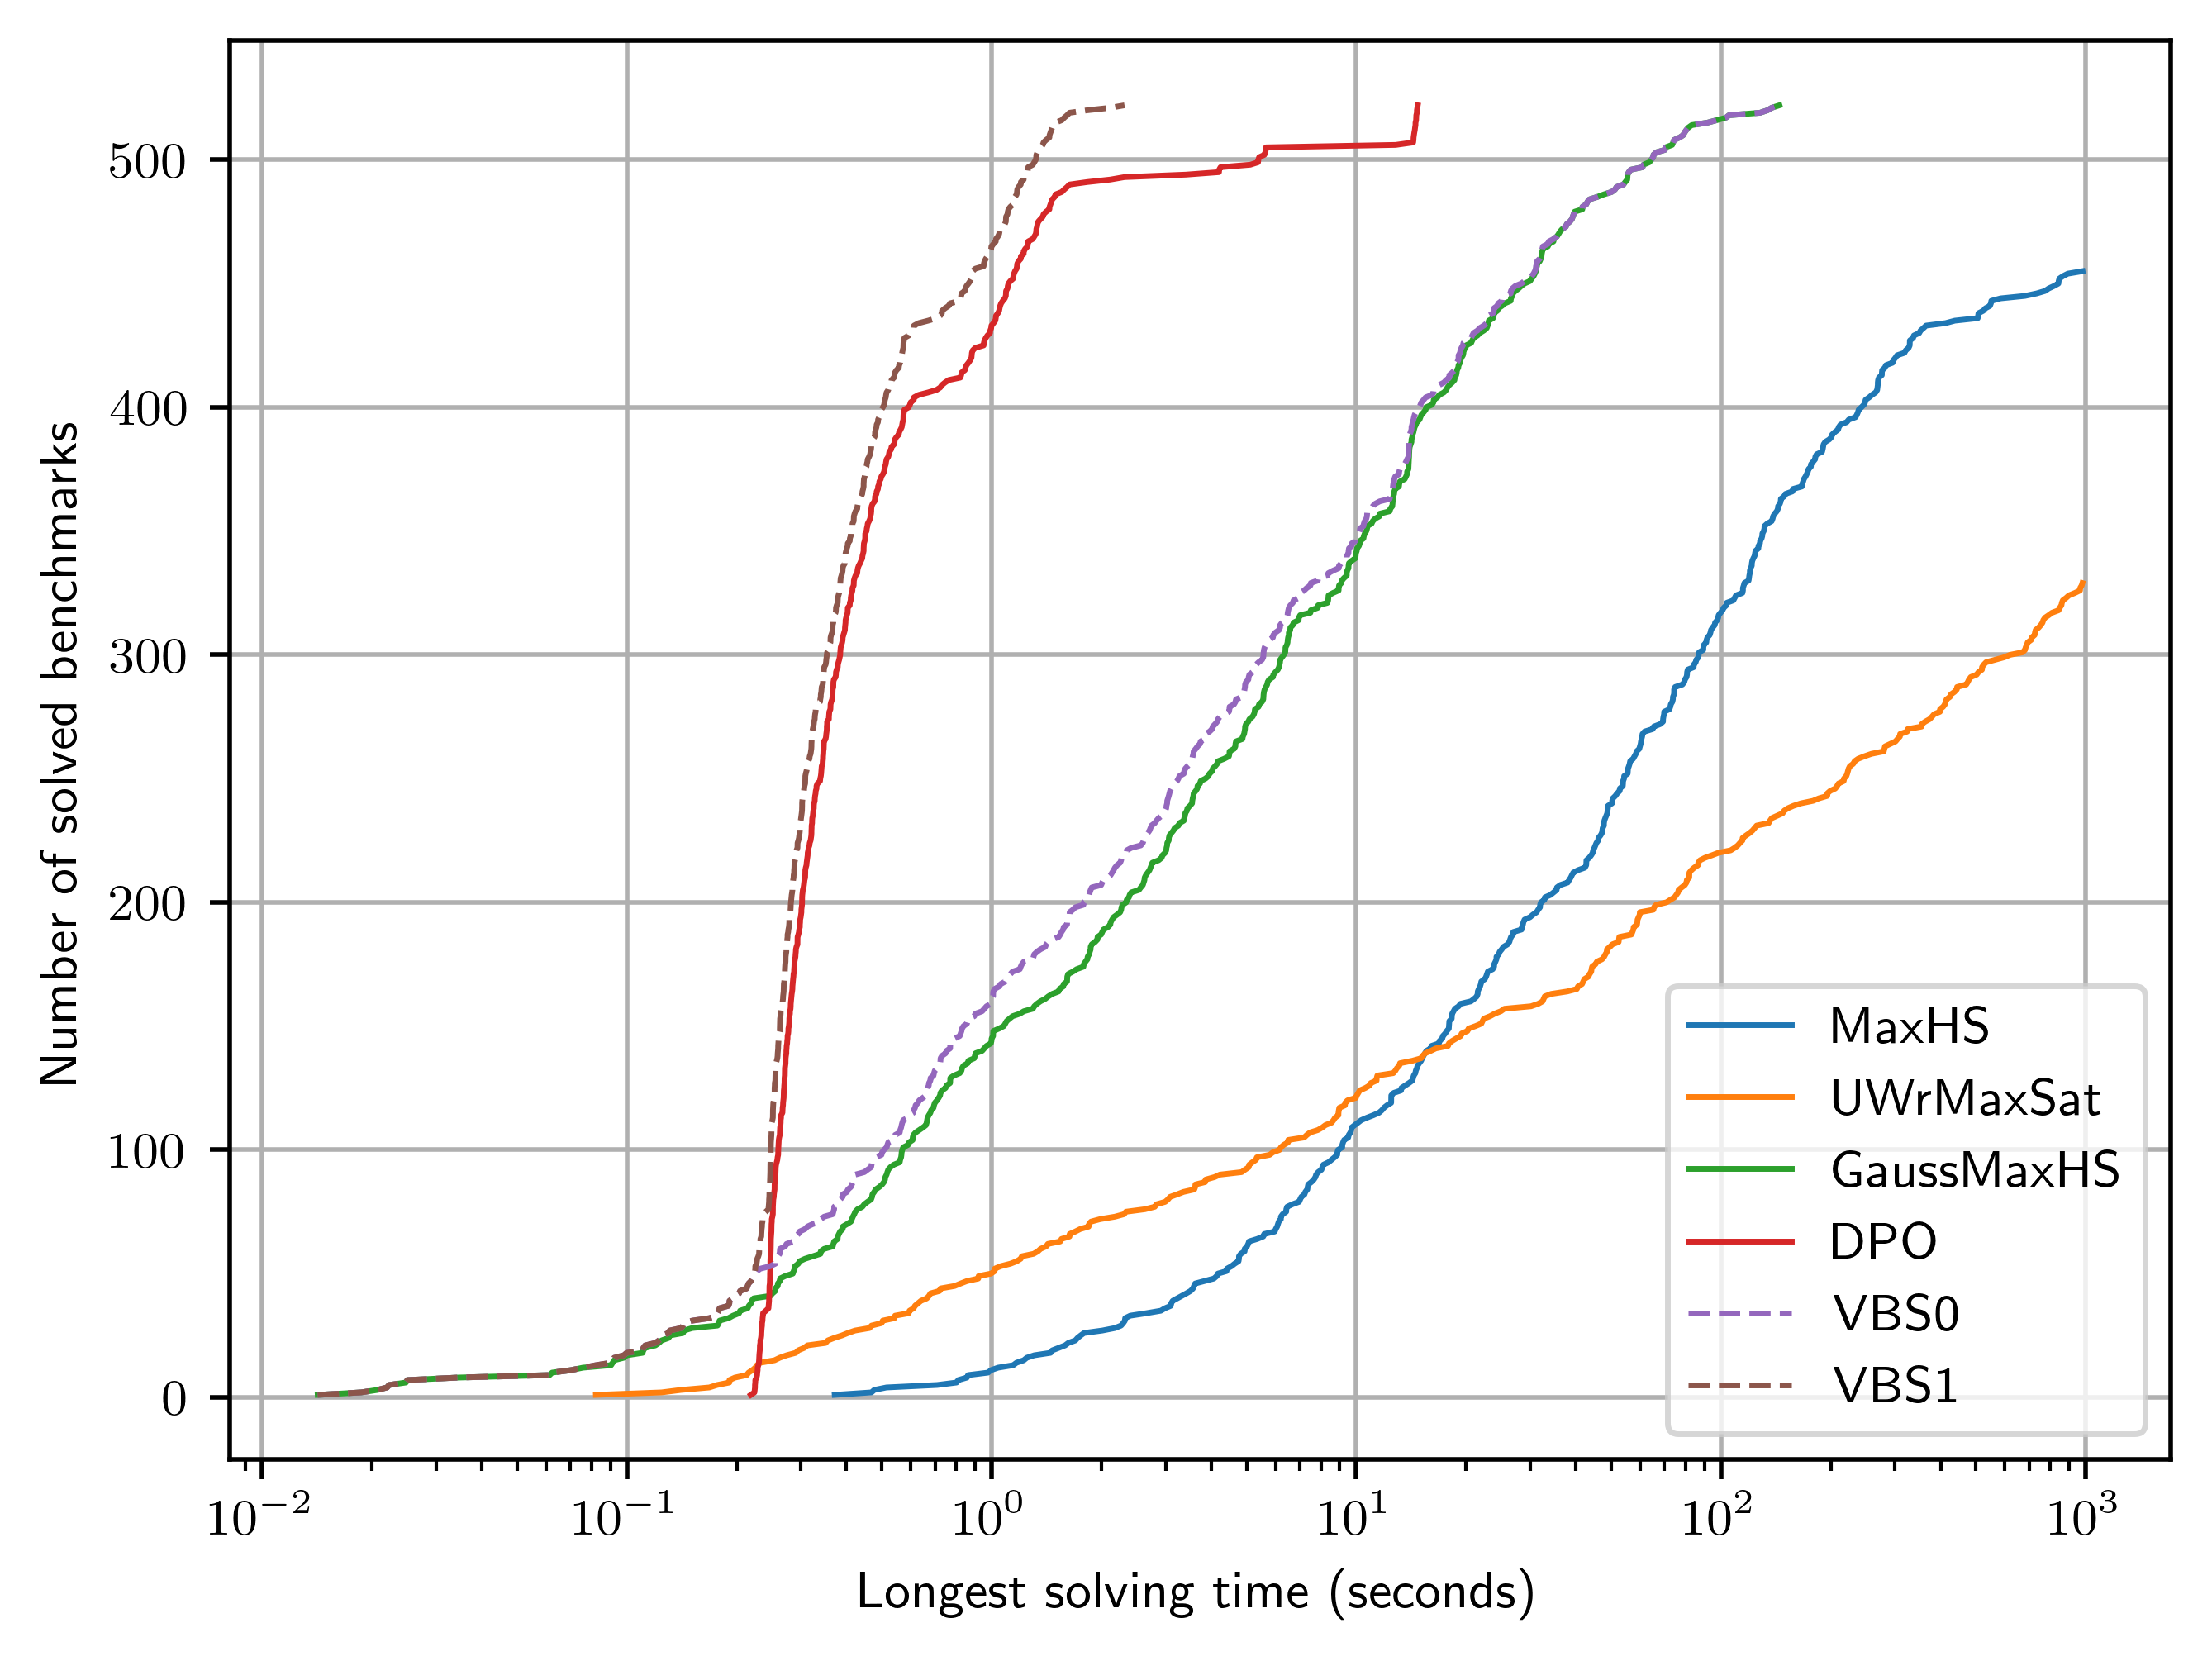

In [46]:
(fig, ax) = getFigAx(.75)

drawSolverCurve(ax, CHAIN0_PERF_TABLE, HS, 'MaxHS', '-')
drawSolverCurve(ax, CHAIN0_PERF_TABLE, UW, 'UWrMaxSat', '-')
drawSolverCurve(ax, CHAIN0_PERF_TABLE, GM, 'GaussMaxHS', '-')
drawSolverCurve(ax, CHAIN0_PERF_TABLE, DNX, 'DPO', '-')

drawVbsCurve(ax, CHAIN0_PERF_TABLE, [HS, UW, GM], 'VBS0', '--')
drawVbsCurve(ax, CHAIN0_PERF_TABLE, [HS, UW, GM, DNX], 'VBS1', '--')

ax.legend(loc='lower right')

saveFig(fig, '/tmp/solvers-chain-easy.pgf')

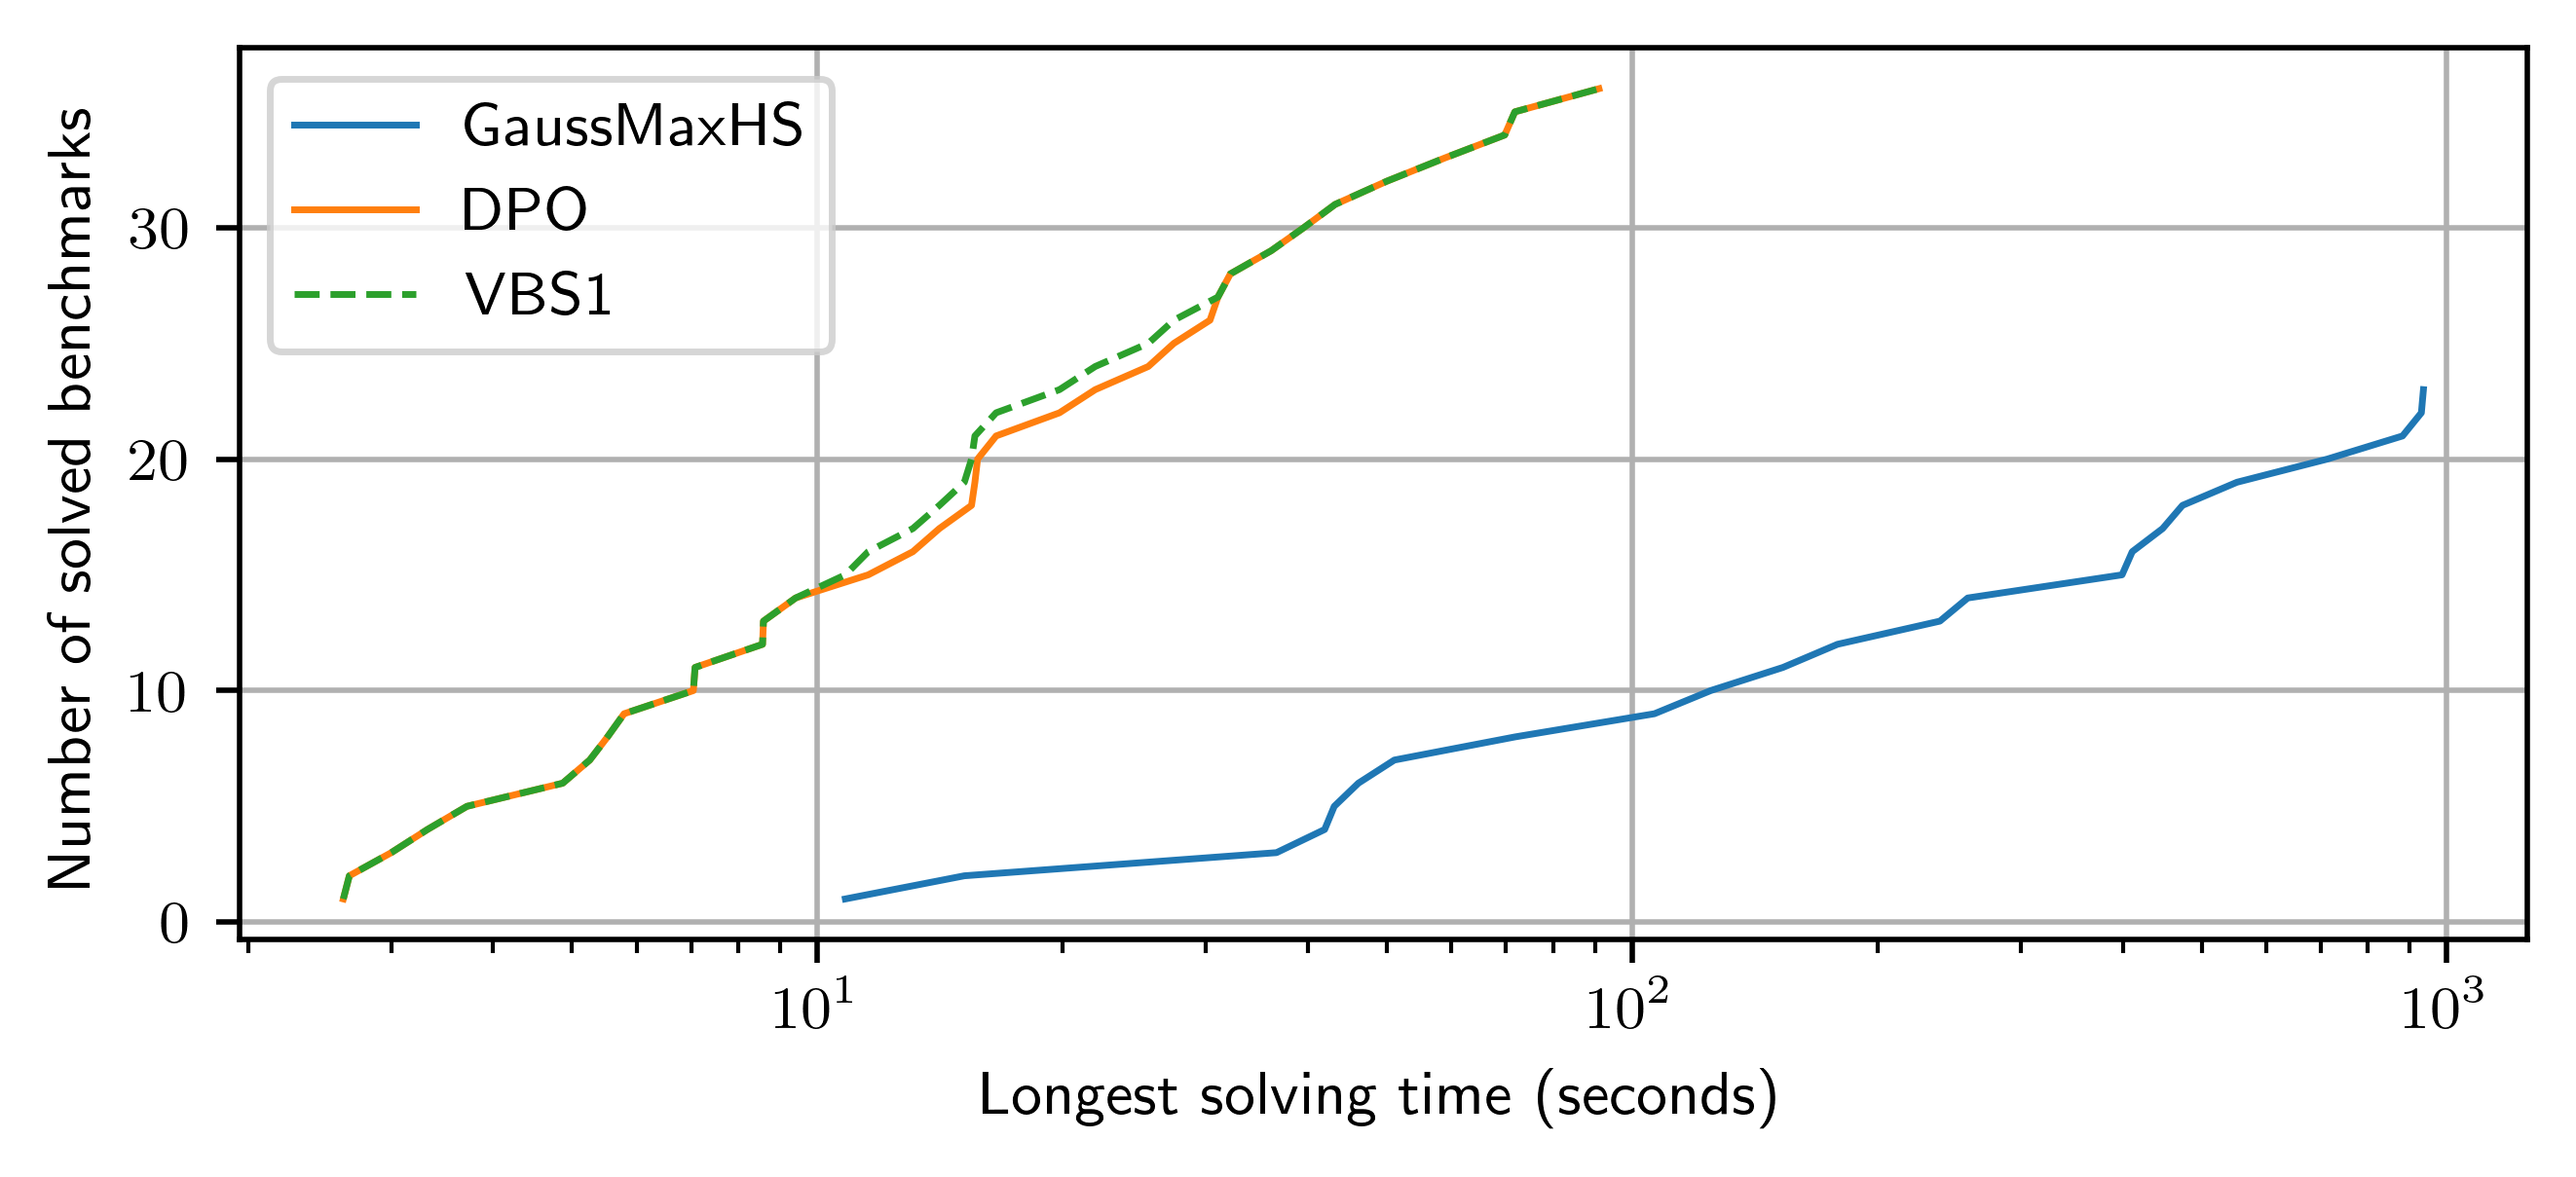

In [47]:
(fig, ax) = getFigAx(.4)

drawSolverCurve(ax, CHAIN1_PERF_TABLE, GM, 'GaussMaxHS', '-')
drawSolverCurve(ax, CHAIN1_PERF_TABLE, DNX, 'DPO', '-')

drawVbsCurve(ax, CHAIN1_PERF_TABLE, [UW, GM, DNX], 'VBS1', '--')

ax.legend(loc='upper left')

saveFig(fig, '/tmp/solvers-chain-hard.pgf')